Huấn luyện mô hình

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.preprocessing import build_preprocessor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [6]:
df = pd.read_csv("../data/raw/train.csv")

y = df["Class/ASD"]
X = df.drop("Class/ASD", axis=1)

In [3]:
def train_test_split_processed(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    preprocessor = build_preprocessor(X_train, y_train)
    
    return preprocessor.transform(X_train), preprocessor.transform(X_test), y_train, y_test

In [36]:
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

def model_with_and_without_LDA(X, y, test_size, model):
    X_train, X_test, y_train, y_test = train_test_split_processed(X, y, test_size)
    
    # Áp dụng SMOTE để xử lý dữ liệu không cân bằng cho các class thiểu số trong tập huấn luyện
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    #Giảm chiều bằng lda
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_train_lda = lda.fit_transform(X_train_resampled, y_train_resampled)
    X_test_lda = lda.transform(X_test)
    
    
    # train và predict với dữ liệu gốc và dữ liệu đã giảm chiều
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    # Đánh giá với cross-validation để có cái nhìn tổng quan hơn về hiệu suất của mô hình
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
    cv_mean = cv_scores.mean()
    
    model.fit(X_train_lda, y_train_resampled)
    y_pred_lda = model.predict(X_test_lda)

   

    print("---Chia theo tỉ lệ: %s---" % test_size)
    print("Độ chính xác chéo với dữ liệu gốc:", cv_mean)
    print("Độ chính xác với dữ liệu gốc:", accuracy_score(y_test, y_pred))
    print("Độ chính xác với dữ liệu đã giảm chiều:", accuracy_score(y_test, y_pred_lda))

    

In [41]:
# Ma trận nhầm lẫn
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("Ma trận nhầm lẫn")
    plt.show()

In [42]:
from sklearn.decomposition import PCA

# Giảm số chiều X_test về 2D
def plot_2d_distribution(X_test, y_test, y_pred):
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test)

    # Hiển thị nhãn thực tế
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, cmap='viridis', alpha=0.7)
    plt.title("Phân bố theo nhãn THỰC TẾ")
    plt.xlabel("Thành phần chính 1")
    plt.ylabel("Thành phần chính 2")

    # Hiển thị nhãn dự đoán
    plt.subplot(1,2,2)
    plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_pred, cmap='viridis', alpha=0.7)
    plt.title("Phân bố theo nhãn DỰ ĐOÁN")
    plt.xlabel("Thành phần chính 1")
    plt.ylabel("Thành phần chính 2")

    plt.tight_layout()
    plt.show()

K-nearest neighbor

In [34]:
# Sử dụng KNN với k=20, p=2 chuẩn L2 norm, weights='distance' 
knn_model = KNeighborsClassifier(n_neighbors=20, p=2, weights='distance')

# Tỉ lệ 4:1
model_with_and_without_LDA(X, y, 0.2, knn_model)
print()
# Tỉ lệ 7:3
model_with_and_without_LDA(X, y, 0.3, knn_model)
print()
# Tỉ lệ 6:4
model_with_and_without_LDA(X, y, 0.4, knn_model)

---Chia theo tỉ lệ: 0.2---
Độ chính xác chéo với dữ liệu gốc: 0.8757281553398059
Độ chính xác với dữ liệu gốc: 0.79375
Độ chính xác với dữ liệu đã giảm chiều: 0.825

---Chia theo tỉ lệ: 0.3---
Độ chính xác chéo với dữ liệu gốc: 0.8741545747070608
Độ chính xác với dữ liệu gốc: 0.7958333333333333
Độ chính xác với dữ liệu đã giảm chiều: 0.8541666666666666

---Chia theo tỉ lệ: 0.4---
Độ chính xác chéo với dữ liệu gốc: 0.8710720651897124
Độ chính xác với dữ liệu gốc: 0.784375
Độ chính xác với dữ liệu đã giảm chiều: 0.821875


In [48]:
X_train, X_test, y_train, y_test = train_test_split_processed(X, y, 0.3)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#Giảm chiều bằng lda
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_resampled, y_train_resampled)
X_test_lda = lda.transform(X_test)

In [55]:

knn = KNeighborsClassifier(n_neighbors=20, p=2, weights='distance')
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)


print("K-nearest Neighbors (KNN) Classification Report:")
print(classification_report(y_test, y_pred))

print("---Giảm chiều LDA---")
knn.fit(X_train_lda, y_train_resampled)
y_pred_lda = knn.predict(X_test_lda)
print(classification_report(y_test, y_pred_lda))

K-nearest Neighbors (KNN) Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       186
           1       0.53      0.91      0.67        54

    accuracy                           0.80       240
   macro avg       0.75      0.84      0.76       240
weighted avg       0.87      0.80      0.81       240

---Giảm chiều LDA---
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       186
           1       0.65      0.78      0.71        54

    accuracy                           0.85       240
   macro avg       0.79      0.83      0.80       240
weighted avg       0.87      0.85      0.86       240



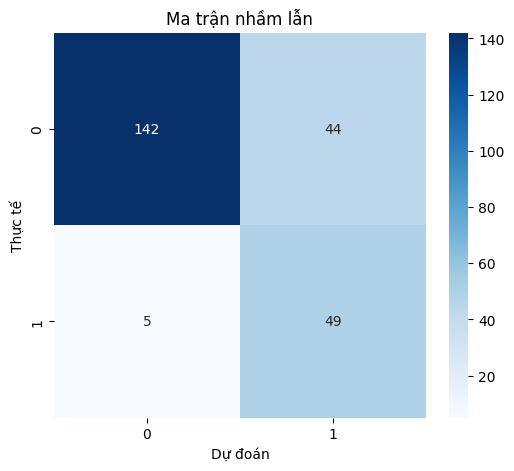

In [43]:
plot_confusion_matrix(y_test, y_pred)


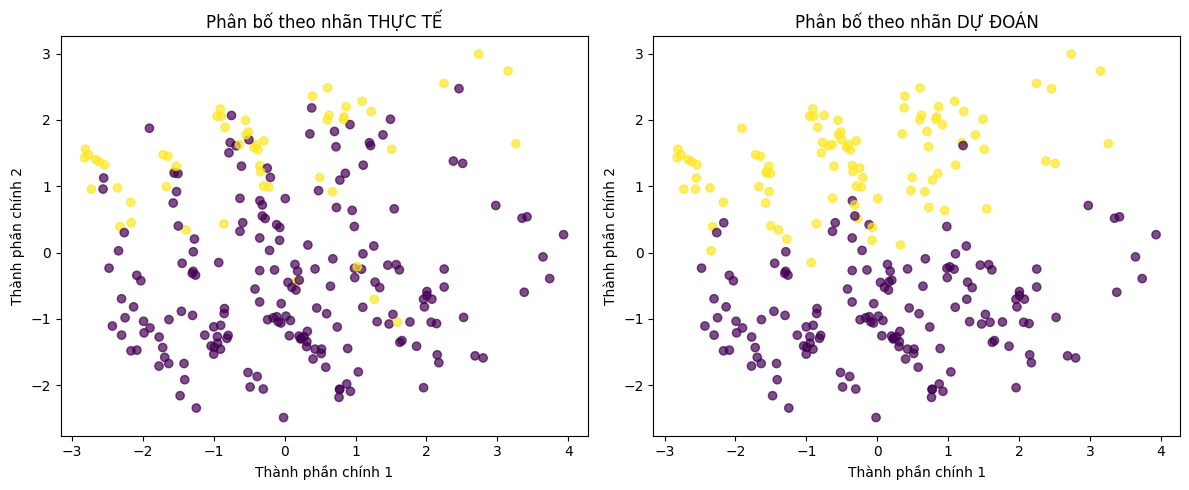

In [40]:
plot_2d_distribution(X_test, y_test, y_pred)


Logistic Regression

In [44]:
lr_model = LogisticRegression(max_iter=1000)

# Tỉ lệ 4:1
model_with_and_without_LDA(X, y, 0.2, lr_model)
print()
# Tỉ lệ 7:3
model_with_and_without_LDA(X, y, 0.3, lr_model)
print()
# Tỉ lệ 6:4
model_with_and_without_LDA(X, y, 0.4, lr_model)

---Chia theo tỉ lệ: 0.2---
Độ chính xác chéo với dữ liệu gốc: 0.8844660194174757
Độ chính xác với dữ liệu gốc: 0.825
Độ chính xác với dữ liệu đã giảm chiều: 0.84375

---Chia theo tỉ lệ: 0.3---
Độ chính xác chéo với dữ liệu gốc: 0.8774937769412908
Độ chính xác với dữ liệu gốc: 0.85
Độ chính xác với dữ liệu đã giảm chiều: 0.8541666666666666

---Chia theo tỉ lệ: 0.4---
Độ chính xác chéo với dữ liệu gốc: 0.8789067142008318
Độ chính xác với dữ liệu gốc: 0.84375
Độ chính xác với dữ liệu đã giảm chiều: 0.846875


In [56]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_resampled, y_train_resampled)
y_pred = lr.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

lr.fit(X_train_lda, y_train_resampled)
y_pred_lda = lr.predict(X_test_lda)

print("---Giảm chiều LDA---")
print(classification_report(y_test, y_pred_lda))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       186
           1       0.63      0.81      0.71        54

    accuracy                           0.85       240
   macro avg       0.78      0.84      0.80       240
weighted avg       0.87      0.85      0.86       240

---Giảm chiều LDA---
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       186
           1       0.64      0.80      0.71        54

    accuracy                           0.85       240
   macro avg       0.79      0.83      0.81       240
weighted avg       0.87      0.85      0.86       240



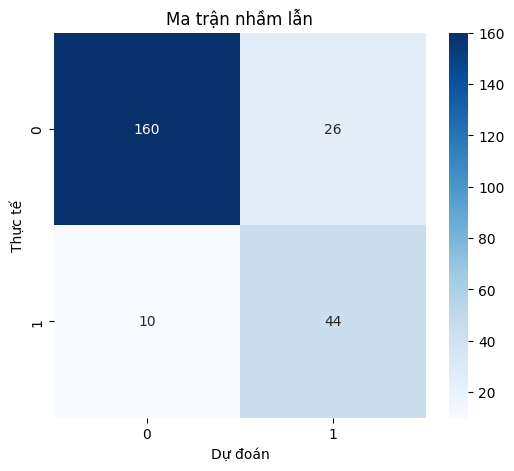

In [46]:
plot_confusion_matrix(y_test, y_pred)

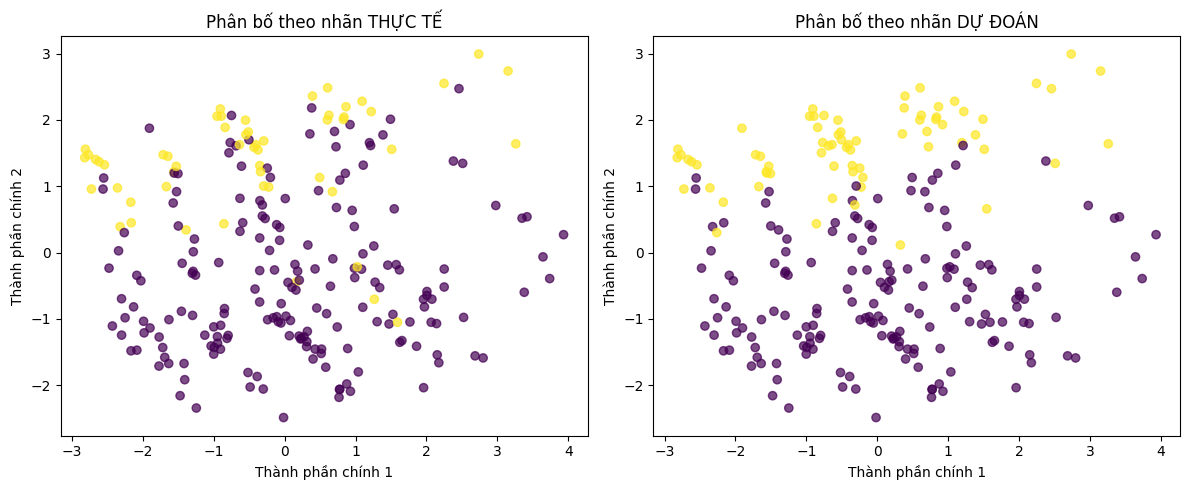

In [47]:
plot_2d_distribution(X_test, y_test, y_pred)